# Geli Data Scientist Assessment

You will have 72 hours to complete the following question.  Reviewers will consider the answer as well as use of best practices and readability. 

## Forecasting assignment

For the provided load data (data/load.csv), create models for a 24 hour multi-step forecast. 

The overall goal for the assignment is to, for each 15 minute time stamp, create a 24 hour ahead time series forecast. In other words, for each timestamp in the file, t, create a forecasted time series for times t+15min, t+30min, ... t + 24* 60min.

Steps that we would like to see:
1. Exploratory Data Analysis: for example, a study of variability and temporal dependence
2. Machine Learning development cycle
3. Error Analysis, including: training-testing split and justification of the metrics used; and analysis of the error.
4. Step-by-step explanation of the methodology used.

Please try two or more prediction models, and explain whether one is better than the other. You will get bonus points for trying probabilistic approaches.

## Loading Required Libraries

In [1]:
# Installing required packaged that aren't available by default
# !pip install xgboost  
# !pip install pmdarima

In [2]:
# Suppression of warnings
import warnings
warnings.filterwarnings('ignore')

# Data management libraries
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

# Time-series analysis and modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pmdarima.arima import ARIMA, auto_arima
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, 
                                     GridSearchCV, RandomizedSearchCV)
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from calendar import month_abbr

# Setting the background theme and font scale for figures
sns.set_theme(style = 'darkgrid', font_scale = 1.1)
# To restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Auxiliary Functions

In [81]:
# Converting month names to their abbrevations
def month_abbrev(month):
    return str(month)[0:3]

# Reporting the MAPE score
def MAPE(y_truth, y_pred):
    mape = 0
    for i in range(len(y_truth)):
        mape += np.abs(y_truth[i] - y_pred[i])/np.abs(y_truth[i])*100
    mape = mape/len(y_truth)
    return mape

# Inverting the MAPE score (helpful in cross-validation grid search 
# whose aim is to maximize the performance score)
def inverse_mape(y1, y2):
    return 1/MAPE(y1, y2)

# Reporting the mean absolute deviation score
def MAD(y_truth, y_pred):
    return mean_absolute_error(y_truth, y_pred)

# Reporting the RMSE score
def RMSE(y_truth, y_pred):
    return np.sqrt(mean_squared_error(y_truth, y_pred))

In [96]:
# Function for annotating the bars in a countplot/barplot
def countplot_labeling(cntplt, data, perc = True, decimal = 1):
    ''' This function gets a countplot and the dataset that has generated
    the plot to produce the values corresponding to each bar (category).
    If perc = True, percentages will be shown.'''

    from math import isnan

    total = data.shape[0]  # total number of values in the dataset
    for p in cntplt.patches:
        height_val = float(p.get_height())
        if(isnan(height_val)):
            height_val = 0
        if(abs(height_val - round(height_val)) < 1e-6):
            height_val = int(height_val)  
        if perc == True:
            # percentage of each category
            label = "{:.1f}%".format(100*height_val/total)
        else:
            label = "{}".format(round(height_val,decimal))  # count of each category
            x = p.get_x() + p.get_width()/2  # width of the plot
            y = p.get_height()  # height of the plot

        if(height_val == 0):
            label = '0'

        # annotate the bar
        cntplt.annotate(label, (x, y), ha = "center", va = "center", 
                        size = 12, xytext = (0, 5), textcoords = "offset points") 

## Loading Dataset

In [4]:
# Importing the data 
data_orig = pd.read_csv('GeliData/load.csv')

# Ensuring the original data remains untouched
data = data_orig.copy()

In [5]:
# Viewing the first and last few rows of the dataset
print('The top 10 rows of the dataset:')
display(data.head(10))
print('\nThe bottom 10 rows of the dataset:')
display(data.tail(10))

The top 10 rows of the dataset:


,0,load
0,2017-10-01 00:00:00,60.63
1,2017-10-01 00:15:00,61.02
2,2017-10-01 00:30:00,59.84
3,2017-10-01 00:45:00,60.82
4,2017-10-01 01:00:00,57.48
5,2017-10-01 01:15:00,60.43
6,2017-10-01 01:30:00,57.67
7,2017-10-01 01:45:00,58.07
8,2017-10-01 02:00:00,58.46
9,2017-10-01 02:15:00,59.45



The bottom 10 rows of the dataset:


,0,load
32150,2018-08-31 21:30:00,72.63
32151,2018-08-31 21:45:00,73.03
32152,2018-08-31 22:00:00,73.22
32153,2018-08-31 22:15:00,74.60
32154,2018-08-31 22:30:00,74.80
32155,2018-08-31 22:45:00,73.81
32156,2018-08-31 23:00:00,75.39
32157,2018-08-31 23:15:00,73.81
32158,2018-08-31 23:30:00,71.85
32159,2018-08-31 23:45:00,73.81


#### Notes:

As can be seen, the dataset begins from October 2017 and ends on August 2018 (11 months of data) and includes the load at each 15-minute interval.

In [6]:
# Checking the number of duplicated rows and missing values
print('No. of duplicated records:', data.duplicated().sum())
print('No. of missing observations:', data.isna().sum().sum())

No. of duplicated records: 0
No. of missing observations: 0


#### Notes:

Thankfully, the dataset has no missing values and duplicated entries.

In [7]:
# Let's build a datetime column for our dataset corresponding to the time range it covers
dt_range = pd.date_range(start = '10/1/2017', end = '9/1/2018', freq = '0.25H') 
dt_range = dt_range[:-1]
len(dt_range)

32160

#### Notes:

As can be seen, the length of the created date range is equal to the no. of rows in the dataset, further confirming that the data is contiguous with no missing values, and all 15-minute intervals have been covered.

In [8]:
# Adding the datetime variable to the data as as index
data['time'] = dt_range
data.drop('0', axis = 1, inplace = True)
data.set_index(keys = 'time', drop = True, inplace = True)
data.head()

,load
time,
2017-10-01 00:00:00,60.63
2017-10-01 00:15:00,61.02
2017-10-01 00:30:00,59.84
2017-10-01 00:45:00,60.82
2017-10-01 01:00:00,57.48


### Feature Creation

Here, we will create a few helpful features that can facilitate data visualization and come in handy with modeling, when a non-ARIMA model is being used. 

In [9]:
data['year'] = data.index.year
data['month'] = data.index.month
data['month_name'] = data.index.month_name()
data['month_name'] = data['month_name'].apply(month_abbrev)
data['day_of_week'] = data.index.weekday
data['day_of_week_name'] = data.index.strftime('%a')
data['hour_of_day'] = data.index.hour
data['hour_of_day_cat'] = pd.Categorical(data['hour_of_day'])
data.head()

,load,year,month,month_name,day_of_week,day_of_week_name,hour_of_day,hour_of_day_cat
time,,,,,,,,
2017-10-01 00:00:00,60.63,2017,10,Oct,6,Sun,0,0
2017-10-01 00:15:00,61.02,2017,10,Oct,6,Sun,0,0
2017-10-01 00:30:00,59.84,2017,10,Oct,6,Sun,0,0
2017-10-01 00:45:00,60.82,2017,10,Oct,6,Sun,0,0
2017-10-01 01:00:00,57.48,2017,10,Oct,6,Sun,1,1


### Notes:

Here, month, day of the week, and hour of the day were engineered based on the expected daily, weekly and annual cyclicality of the load. For the sake of easier visualization, the categorical equivalents of the hour of the day, the day of the week and the month of the year were generated, as well, .   

## Exploratory Data Analysis

### Statistical Summary

In [10]:
# Numerical variables
print('Statistical summary of load')
display(data.load.describe())

# Categorical variables
print('\nStatistical summary of categorical variables')
display(data.describe(include = ['object', 'category']).T)

Statistical summary of load


count   32160.00
mean      103.20
std        40.73
min        37.20
25%        67.52
50%        87.59
75%       138.58
max       220.85
Name: load, dtype: float64


Statistical summary of categorical variables


,count,unique,top,freq
month_name,32160,11,Oct,2976
day_of_week_name,32160,7,Sun,4608
hour_of_day_cat,32160,24,0,1340


#### Notes:

*   The averge load on the system is ~ 103 MW (?), while its minimum and maximum are around 40 and 225, respectively, signaling slight right-skewedness. 
*   The standard deviation of the load is more than 1/3 of its mean, indicating the high variability of the load. 
*   As expected, there are 24 unique values for hour of the day, 7 unique day of the week, and 11 unique months. 

### Plotting Full TS Along WIth Its Snapshots

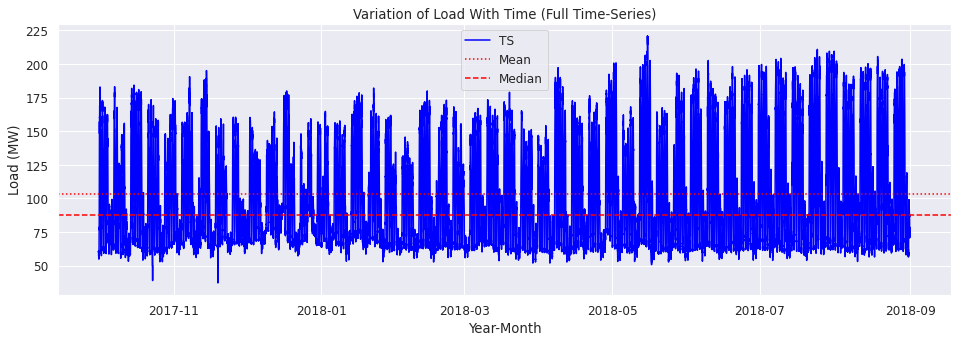

In [11]:
plt.figure(figsize = (16, 5));
plt.plot(data.index, data.load, color = 'blue');
plt.axhline(data.load.mean(), color = 'red', linestyle = ':');
plt.axhline(data.load.median(), color = 'red', linestyle = '--');
plt.legend(['TS', 'Mean', 'Median'], loc = 'best');
plt.xlabel('Year-Month');
plt.ylabel('Load (MW)');
plt.title('Variation of Load With Time (Full Time-Series)');

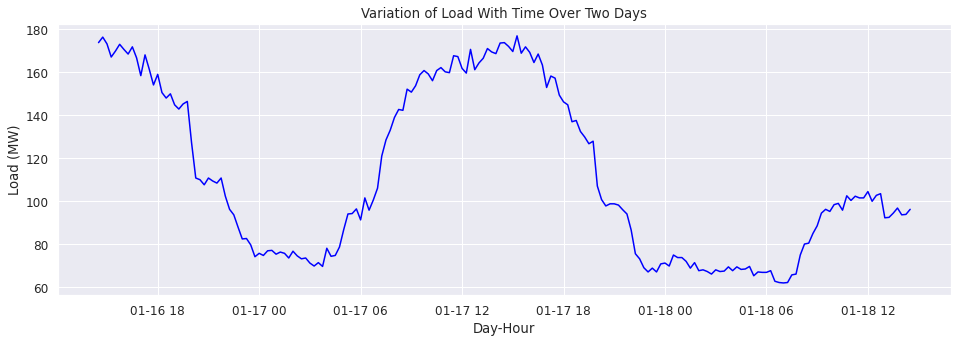

In [12]:
# generating a random index which is the center of the plot
from random import randint, seed
seed(100)
rand_index = randint(int(0.25*data.shape[0]), int(0.75*data.shape[0])+1)

# Starting and ending indices of the plot
i_s = rand_index - 24*4
i_e = rand_index + 24*4

# Plotting the load one day to the left and right of the random index 
plt.figure(figsize = (16, 5));
plt.plot(data.index[i_s:i_e+1], data.load[i_s:i_e+1], color = 'blue');
plt.xlabel('Day-Hour');
plt.ylabel('Load (MW)');
plt.title('Variation of Load With Time Over Two Days');

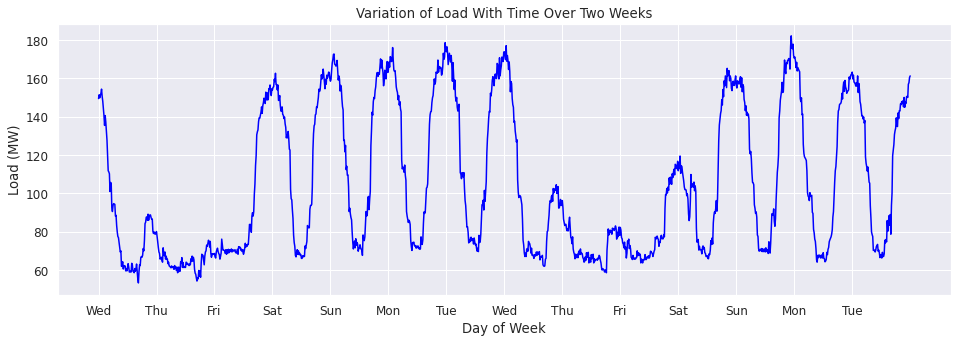

In [13]:
# generating a random index which is the center of the plot
seed(100)
rand_index = randint(int(0.25*data.shape[0]), int(0.75*data.shape[0])+1)

# Creating one unit of day
day_unit = (data.index[i_s] - data.index[i_s-1])*4*24

# Starting and ending indices of the plot
i_s = rand_index - 24*4*7
i_e = rand_index + 24*4*7

# Plotting the load one week to the left and right of the random index 
plt.figure(figsize = (16, 5));
plt.plot(data.index[i_s:i_e+1], data.load[i_s:i_e+1], color = 'blue');
plt.xlabel('Day of Week');
plt.ylabel('Load (MW)');
plt.xticks(np.arange(data.index[i_s], data.index[i_e], day_unit), 
           list(pd.to_datetime(np.arange(data.index[i_s],
                               data.index[i_e], day_unit)).strftime('%a')))
plt.title('Variation of Load With Time Over Two Weeks');

#### Notes:

*   The full TS plot exhibits that load has several periodicities of different scales, but since it's a whole plot, these periodicities can't be clearly differentiated from one another.
*   The plot over two days shows that the load peaks sometime in the afternoon and is the lowest during the early hours of the day.
*   The two-week plot indicates that the load is significantly reduced on Thursdays and Fridays.

### Hourly Distribution of Load

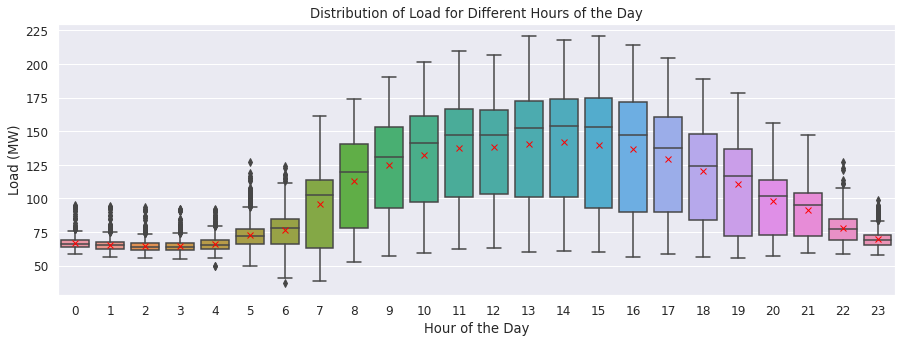

In [14]:
plt.figure(figsize = (15, 5));
sns.boxplot(data = data, x = 'hour_of_day_cat', y = 'load', showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '5.5'});
plt.xlabel('Hour of the Day')
plt.ylabel('Load (MW)')
plt.title('Distribution of Load for Different Hours of the Day');

#### Observations: 

*   As previously discussed, for the early hours of day, the load is the lowest, and it is maximized sometime around 3 pm.
*   The red crosses in boxplots show the mean values.


### Daily (Day of Week) Distribution of Load

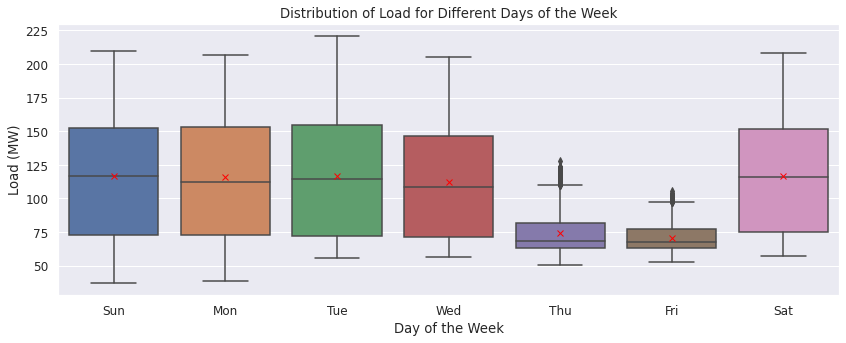

In [15]:
plt.figure(figsize = (14, 5));
sns.boxplot(data = data, x = 'day_of_week_name', y = 'load', showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '5.5'});
plt.xlabel('Day of the Week')
plt.ylabel('Load (MW)')
plt.title('Distribution of Load for Different Days of the Week');

#### Observations:

As already established, Thursday and Friday have the lowest load, compared to other days of week.

### Monthly Distribution of Load

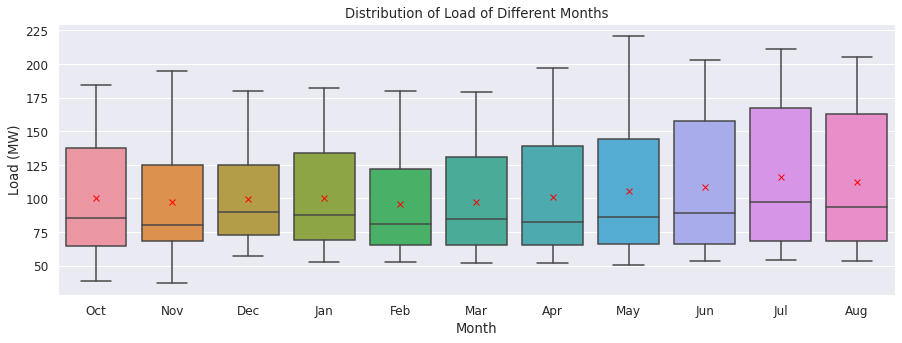

In [16]:
plt.figure(figsize = (15, 5));
sns.boxplot(data = data, x = 'month_name', y = 'load', showmeans = True,
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '5.5'});
plt.xlabel('Month')
plt.ylabel('Load (MW)')
plt.title('Distribution of Load of Different Months');

#### Observations:

However the impact of month isn't as stark as the day of the week or hour of the day, but we can conclude that the load on the grid is higher during the warmer months.

### Variation of Load of Different Days of Week Over Various Months

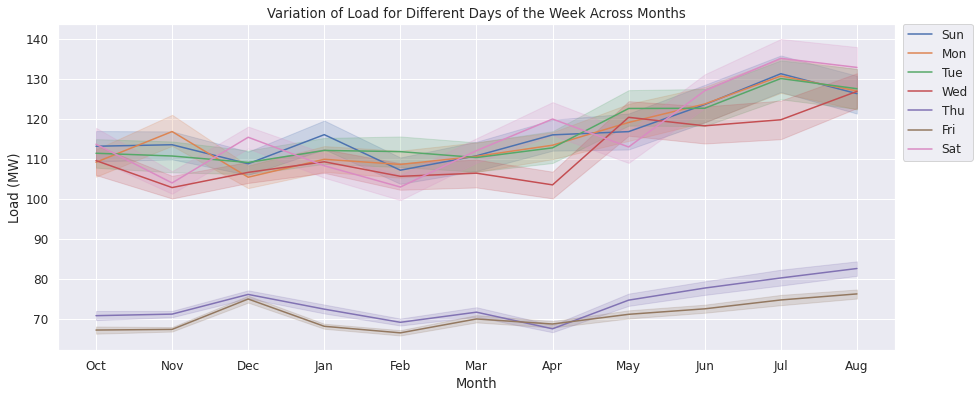

In [17]:
plt.figure(figsize = (15, 6));
sns.lineplot(data = data, x = 'month_name', y = 'load', hue = 'day_of_week_name');
plt.xlabel('Month');
plt.ylabel('Load (MW)');
plt.legend(bbox_to_anchor = [1.1, 1.02]);
plt.title('Variation of Load for Different Days of the Week Across Months');

#### Observations:

The lineplot again highlights that the grid load on Thursdays and Fridays is much lower that any other day of the week, and with the gradual increase in the temperature, the average monthly load rises. 

### Seasonal Decompositon of Load 

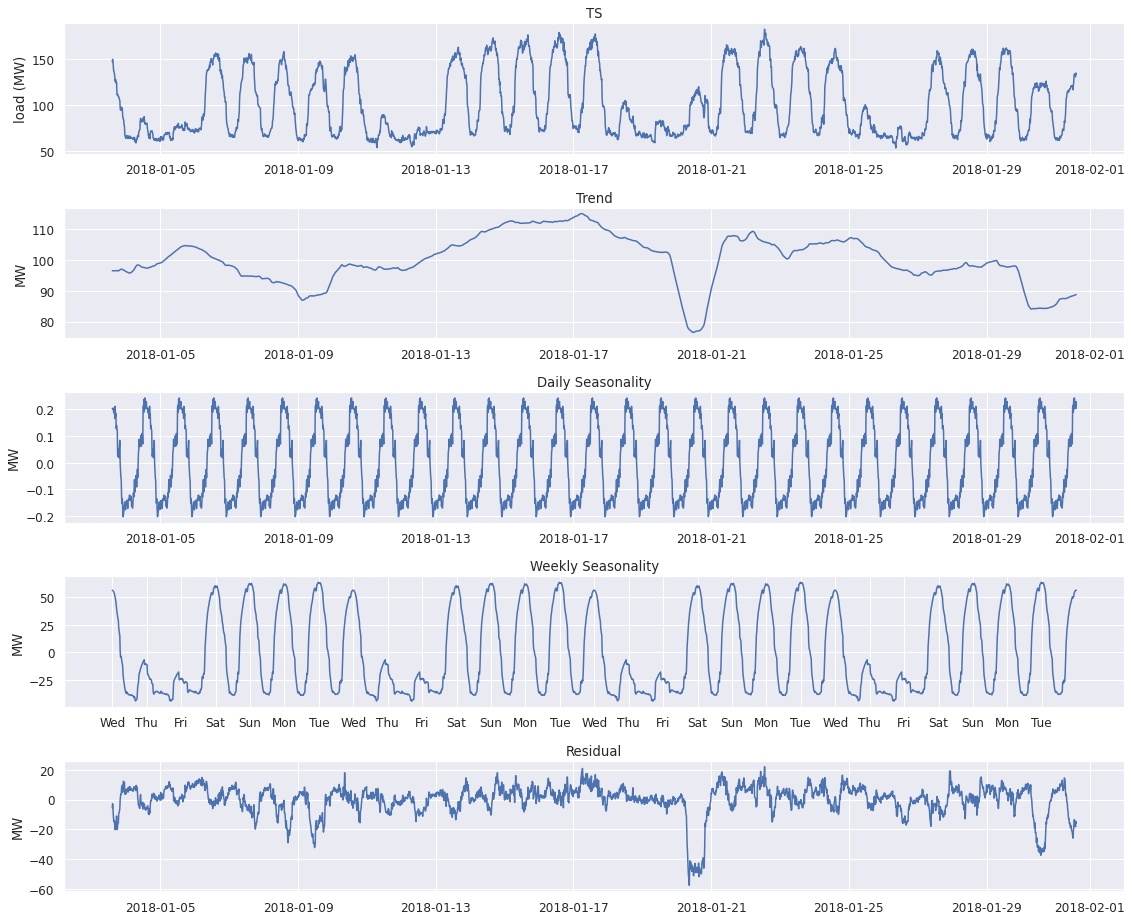

In [18]:
# Decomposing the time series using a weekly period
load_decomposed_weekly = seasonal_decompose(data['load'], model = 'additive', period = 7*24*4);
# Decomposing the TS using a daily period after removing the weekly seasonality
load_decomposed_daily = seasonal_decompose(data['load'] - load_decomposed_weekly.seasonal, 
                                            model = 'additive', period = 24*4);

# generating a random index which is the center of the plot
seed(100)
rand_index = randint(int(0.25*data.shape[0]), int(0.75*data.shape[0])+1)

# Starting and ending indices of the plot
i_s = rand_index - 14*24*4
i_e = rand_index + 14*24*4

# Plotting the TS, trend and seasonalities for a period of four weeks 
plt.figure(figsize = (16, 13));
plt.subplot(511);
plt.plot(data.load[i_s:i_e+1]);
plt.title('TS');
plt.ylabel('load (MW)');
plt.subplot(512);
plt.plot(load_decomposed_daily.trend[i_s:i_e+1]);
plt.title('Trend');
plt.ylabel('MW');
plt.subplot(513);
plt.plot(load_decomposed_daily.seasonal[i_s:i_e+1]);
plt.title('Daily Seasonality');
plt.ylabel('MW');
plt.subplot(514);
plt.plot(load_decomposed_weekly.seasonal[i_s:i_e+1]);
plt.xticks(np.arange(data.index[i_s], data.index[i_e], day_unit), 
           list(pd.to_datetime(np.arange(data.index[i_s],
                               data.index[i_e], day_unit)).strftime('%a')));
plt.title('Weekly Seasonality');
plt.ylabel('MW');
plt.subplot(515);
plt.plot(load_decomposed_weekly.resid[i_s:i_e+1]);
plt.title('Residual');
plt.ylabel('MW');
plt.tight_layout();

#### Observations:

*   The TS has been decomposed by separately identifying daily and weekly seasonalities. The former has been extracted after removing the weekly seasonality.
*   The weekly seasonality plot also demonstrates some kind of daily seasonality (look at the peaks), since it's been obtained before extracting the daily seasonality.
*   Since the TS is short, the annual seasonality couldn't be captured.
*   The residual doesn't reveal a clear pattern, meaning that decomposition has been handled properly. There still might be some patterns and correlations in residuals as due to the shortcomings of this step-by-step approach.

## ARIMA-Based Time-Series Forecasting

*   The first method chosen for developing a predictive model is SARIMAX. 
*   Since SARIMAX only accepts one seasonality, we will take a mult-step approach: First, we develop a model that actcurately predicts daily-averaged data, while capturing the month-to-month trend and the weekly seasonality. Then, a second method is developed, which forecasts the hourly variations around the daily mean. 
*   Any effort to capture the 15-minute or hourly variations along with the overall trend and weekly and daily seasonalities in one attempt (and by including the larger seasonalities as exogenous Fourier terms) only led to system crash and running out of memory. This is why the above stepwise approach was devised.
*   Even with a multi-step approach, developing a model capable of predicting on 15-minute intervals was beyond my computational resources and repeatedly led to kernel crash. Therefore, while using SARIMAX, I only made predictions on an hourly basis, and interpolated that on 15-minute intervals.

In [19]:
# Preparing training and testing data

# Downsampling data on hourly basis
data_arima = data['load'].resample('H').mean()
# Splitting the data into training and test sets (keeping the last month for testing)
train_arima, test_arima = train_test_split(data_arima, train_size = 300*24, shuffle = False) 

In [20]:
# Generating datasets that are daily based
data_arima_daily = data_arima.resample('D').mean()
train_arima_daily = train_arima.resample('D').mean()
test_arima_daily = test_arima.resample('D').mean()

In [21]:
# ADF test on daily-averaged data
adf_results = adfuller(train_arima_daily, regression = 'ct', maxlag = 30)
print('The result of augmented Dickey-Fuller test on the daily-averaged load data:\n')
print('test statistic =', round(adf_results[0], 4))
print('p-value =', round(adf_results[1], 4))
print('no. of lags used =', adf_results[2])
print('no. of observations used =', adf_results[3])

The result of augmented Dickey-Fuller test on the daily-averaged load data:

test statistic = -2.7466
p-value = 0.2173
no. of lags used = 21
no. of observations used = 278


#### Notes:

As anticipated, due to month-to-month trend, the (daily) data isn't stationary, which is something to be considered while developing an ARIMA-based model.

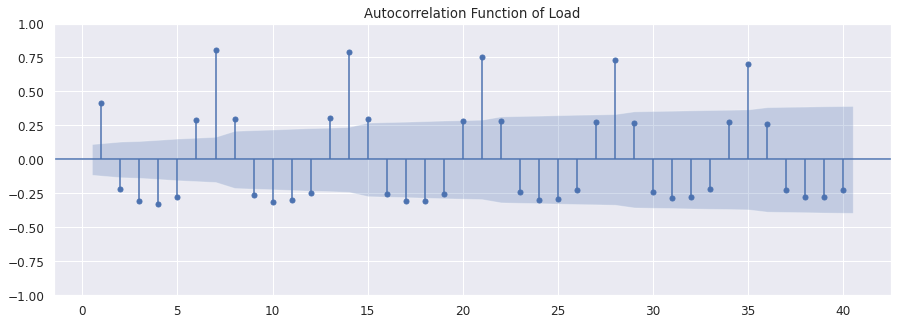

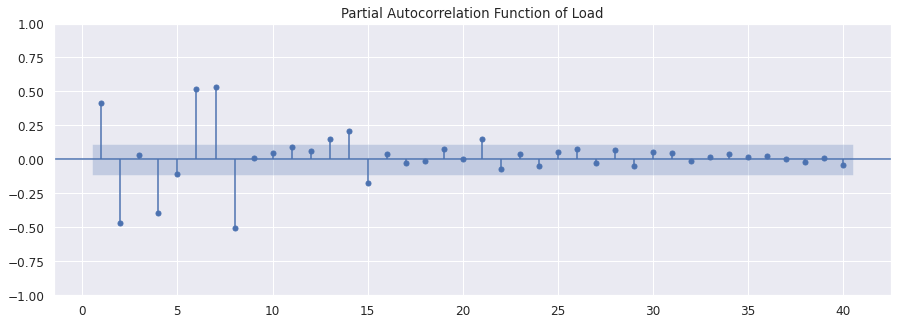

In [22]:
# Producing autocorrelation plots
from pylab import rcParams
# Plotting ACF helpful with choosing q (and Q)
rcParams['figure.figsize'] = 15, 5
plot_acf(train_arima_daily, lags = 40, zero = False, title = 'Autocorrelation Function of Load');
plt.show();
# Plotting PACF helpful with choosing p (and P)
rcParams['figure.figsize'] = 15, 5
plot_pacf(train_arima_daily, lags = 40, zero = False, method = 'ywm', 
          title = 'Partial Autocorrelation Function of Load');
plt.show();

#### Notes:

The autocorrelation plots helps to pass reasonable values for maximum p, q, P and Q to the model.

In [23]:
# Building a daily model capable of capturing month-to-month trend and weekly seasonality
arima_model_daily = auto_arima(train_arima_daily, seasonal = True, m = 7, maxiter = 100,
                               start_q = 1, start_p = 1, max_q = 5, max_p = 3, 
                               max_P = 2, max_Q = 4)

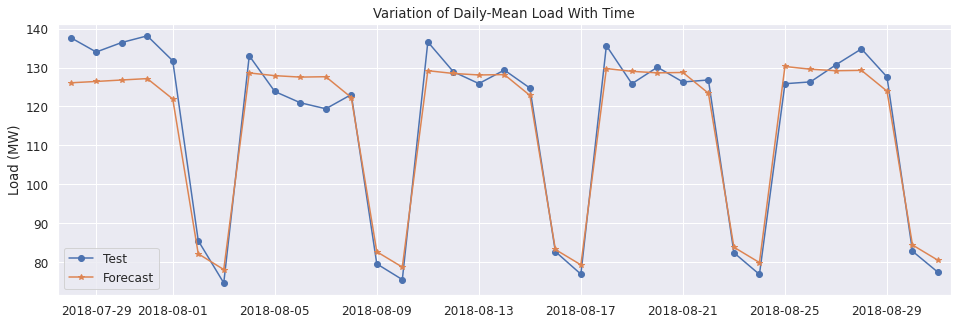

In [24]:
# Showcasing the performance of the daily model
arima_daily_forecast = arima_model_daily.predict(len(test_arima_daily))
plt.figure(figsize = (16, 5));
plt.plot(test_arima_daily, marker = 'o');
plt.plot(arima_daily_forecast, marker = '*');
plt.xlim(test_arima_daily.index[0]-0.5*day_unit, test_arima_daily.index[-1]+0.5*day_unit)
plt.legend(['Test', 'Forecast'], loc = 'best');
plt.ylabel('Day');
plt.ylabel('Load (MW)');
plt.title('Variation of Daily-Mean Load With Time');

#### Observations:

As can be seen, the first model is very skilled in capturing the overall trend, weakly seasonality and producing daily predictions.

In [25]:
# Calculating daily means and upsampling them for each timestamp
daily_mean_train = pd.Series(index = train_arima.index)
daily_mean_train.iloc[:-23] = train_arima_daily.resample('H').interpolate(method = 'ffill')
daily_mean_train.iloc[daily_mean_train.isnull()] = daily_mean_train[-24]

daily_mean_test = pd.Series(index = test_arima.index)
daily_mean_test.iloc[:-23] = test_arima_daily.resample('H').interpolate(method = 'ffill')
daily_mean_test.iloc[daily_mean_test.isnull()] = daily_mean_test[-24]

# Removing daily means from TS of training and testing data 
# and scaling them with the magnitude of mean daily load
train_perturb = (train_arima - daily_mean_train)/daily_mean_train
test_perturb = (test_arima - daily_mean_test)/daily_mean_test

#### Notes:

In the previous step, we have removed the daily mean from the hourly data to prepare it for the second model (hourly model working with perturbation data). Normalizing the data with daily mean further reduces the weekly effect.    

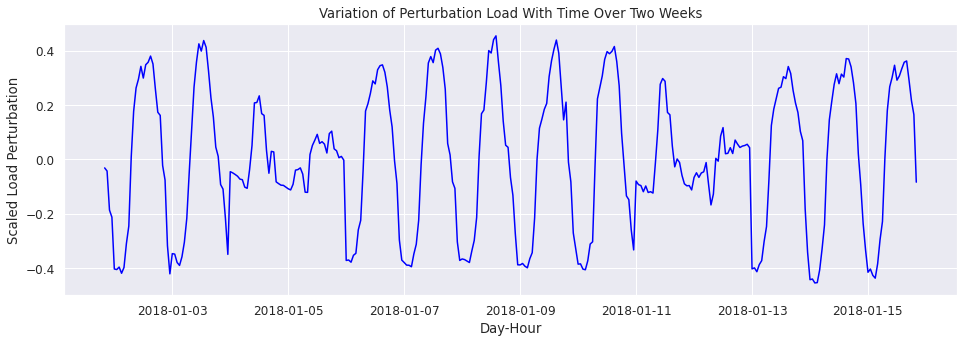

In [26]:
# generating a random index which is the center of the plot
from random import randint, seed
seed(100)
rand_index = randint(int(0.25*train_perturb.shape[0]), int(0.75*train_perturb.shape[0])+1)

# Starting and ending indices of the plot
i_s = rand_index - 24*7
i_e = rand_index + 24*7

# Plotting the load one day to the left and right of the random index 
plt.figure(figsize = (16, 5));
plt.plot(train_perturb.index[i_s:i_e+1], train_perturb[i_s:i_e+1], color = 'blue');
plt.xlabel('Day-Hour');
plt.ylabel('Scaled Load Perturbation');
plt.title('Variation of Perturbation Load With Time Over Two Weeks');

#### Observations:

As can be seen, even after removing the daily mean and scaling the data, although to a reduced extent, the weekly seasonality still appears. Thus, it'd be incisive to include exogenous terms in the hourly model reflecting the weekly effect. 

In [26]:
# ADF test on hourly perturbation data
adf_results = adfuller(train_perturb, regression = 'ct', maxlag = 30)
print('The result of augmented Dickey-Fuller test on the hourly load perturbation sales data:\n')
print('test statistic =', round(adf_results[0], 4))
print('p-value =', round(adf_results[1], 4))
print('no. of lags used =', adf_results[2])
print('no. of observations used =', adf_results[3])

The result of augmented Dickey-Fuller test on the hourly load perturbation sales data:

test statistic = -17.7164
p-value = 0.0
no. of lags used = 30
no. of observations used = 7169


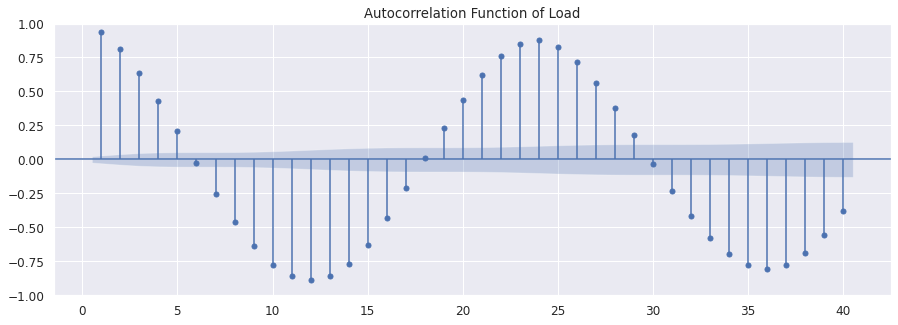

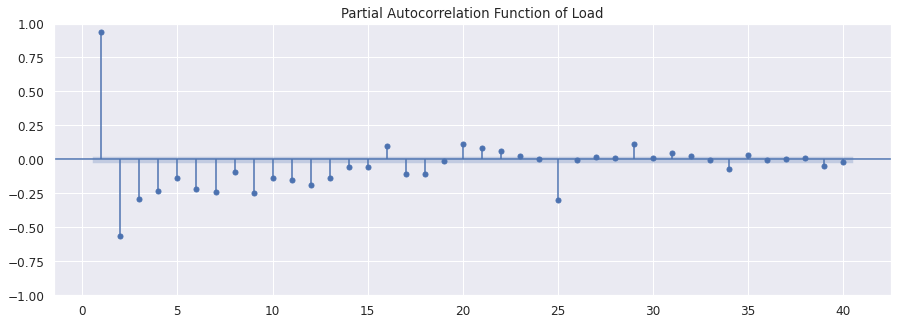

In [27]:
# Producing autocorrelation plots
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
# Plotting ACF helpful with choosing q (and Q)
plot_acf(train_perturb, lags = 40, zero = False, title = 'Autocorrelation Function of Load');
plt.show();
# Plotting PACF helpful with choosing p (and P)
rcParams['figure.figsize'] = 15, 5
plot_pacf(train_perturb, lags = 40, zero = False, method = 'ywm', 
          title = 'Partial Autocorrelation Function of Load');
plt.show();

#### Observations:

*   The ADF test shows that the removal of the trend has rendered the TS stationary. 
*   The autocorrelation plots indicate that the values chosen for the limits of (p, q) and (P, Q) should be larger than those selected for the daily model.

In [28]:
# Capturing the weekly effect through exogenous terms
exog_train = pd.DataFrame(index = train_arima.index)
exog_train['weekly_effect'] = train_arima.index.dayofweek
exog_test = pd.DataFrame(index = test_arima.index)
exog_test['weekly_effect'] = test_arima.index.dayofweek

# Building a model capable of capturing hourly perturbations around daily mean 
#arima_model_pert = auto_arima(train_perturb[-42*24:], X = exog_train[-42*24:], 
#                              seasonal = True, stationary = True, m = 24, maxiter = 100,
#                              start_q = 2, start_p = 2, max_q = 5, max_p = 8,
#                              max_P = 4, max_Q = 4, trace = True)

# Speeding up the process of model building for the future executions of the code 
# by using the optimal hyperparameters found via auto_arima in the first iteration 
arima_model_pert = ARIMA(maxiter = 100, order = (4,0,0), 
                         seasonal_order = (4,0,1,24),
                         suppress_warnings = True)
arima_model_pert.fit(train_perturb[-42*24:], X = exog_train[-42*24:])

ARIMA(maxiter=100, order=(4, 0, 0), seasonal_order=(4, 0, 1, 24),
      suppress_warnings=True)

#### Notes:

*   Here, the model is being trained only over the past 6 weeeks, in order to avoid long-term dependencies, i.e., predicting the perturbations over the next 24 hours doesn't need data from 10 months ago. Note that the long-term trend and seasonality have already been captured.
*   Another reason to limit the size of training data for the second model was computational constraints.
*   Again, because of computational restraints, a very wide range of values for hyperparameters of ARIMA couldn't be tried. 
*   Six weeks may look too long for predicting only the perturbations in the next two hours, but it'd help model to understand weekly effects better. 
*   Since the search over optimal hyperparameters using auto-ARIMA takes a very long time, the lines executing auto_arima were commented out, and the hyperparameters it returned the first time, were passed to the ARIMA model. 

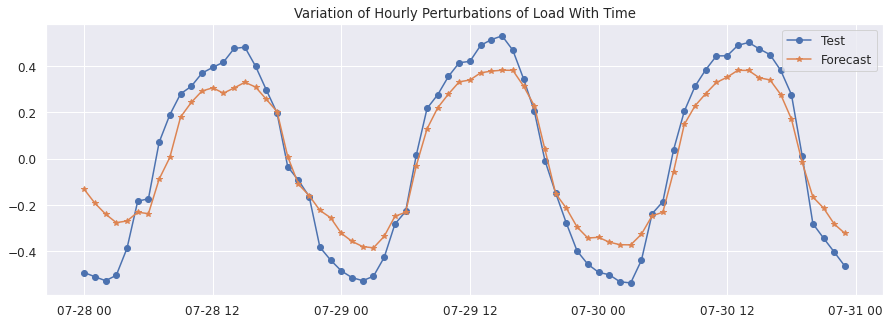

In [29]:
# Showcasing the performance of the hourly model
arima_hourly_forecast = arima_model_pert.predict(72, X = exog_test[:72])
plt.figure(figsize = (15, 5));
plt.plot(test_perturb[:72], marker = 'o');
plt.plot(arima_hourly_forecast, marker = '*');
plt.legend(['Test', 'Forecast'], loc = 'best');
plt.title('Variation of Hourly Perturbations of Load With Time');

#### Observations:

As can be seen, the hourly perturbations have been captured reasonably well by the second model. 

### Automation of the ARIMA Model

Now that we have established the multi-step approach works reasonably well, we will automate the process and combine the two steps using the following functions.

In [30]:
def create_weekly_and_hourly_data(data, train_days):
    '''This function receives the original data sampled every 15 minutes and returns
    hourly- and daily-averaged training and test sets as well as scaled hourly 
    perturbations around the daily mean. It also generates the exogenous terms
    that might be used in models, to reflect the weekly effect.'''
    
    # Downsampling data on hourly basis
    data_hourly = data['load'].resample('H').mean()
    # Splitting the data into training and test sets (keeping the last month for testing)
    train_hourly, test_hourly = train_test_split(data_hourly, train_size = train_days*24,
                                                 shuffle = False) 
    
    # Generating datasets that are daily based
    train_daily = train_hourly.resample('D').mean()
    test_daily = test_hourly.resample('D').mean()
    
    # Calculating daily means and upsampling them for each timestamp
    daily_mean_train = pd.Series(index = train_hourly.index)
    daily_mean_train.iloc[:-23] = train_daily.resample('H').interpolate(method = 'ffill')
    daily_mean_train.iloc[daily_mean_train.isnull()] = daily_mean_train[-24]

    daily_mean_test = pd.Series(index = test_hourly.index)
    daily_mean_test.iloc[:-23] = test_daily.resample('H').interpolate(method = 'ffill')
    daily_mean_test.iloc[daily_mean_test.isnull()] = daily_mean_test[-24]

    # Removing daily means from TS of training and testing data 
    # and scaling them with the magnitude of mean daily load
    train_perturb = (train_hourly - daily_mean_train)/daily_mean_train
    test_perturb = (test_hourly - daily_mean_test)/daily_mean_test
    
    # Capturing the weekly effect through exogenous terms
    exog_train = pd.DataFrame(index = train_hourly.index)
    exog_train['weekly_effect'] = train_hourly.index.dayofweek
    exog_test = pd.DataFrame(index = test_hourly.index)
    exog_test['weekly_effect'] = test_hourly.index.dayofweek

    return (train_hourly, test_hourly, train_daily, test_daily,
            train_perturb, test_perturb, exog_train, exog_test) 

In [31]:
def build_daily_and_hourly_models(train_daily, train_perturb, exog_train,
                                  max_pqPQ_daily, max_pqPQ_perturb):
    '''This function receives daily-averaged and perturbation data and builds two models:
    One that captures daily mean, month-to-month trend and weekly seasonality, and the 
    other which forecasts hourly variations around the daily mean. The function also gets the 
    maximum values for p, q, P and Q, which user determines via autocorrelation-based
    considerations.'''
   
    # Building a daily model capable of capturing month-to-month trend and weekly seasonality
    arima_model_daily = auto_arima(train_daily, seasonal = True, m = 7, maxiter = 100,
                                   start_q = 1, start_p = 1, 
                                   max_p = max_pqPQ_daily[0], max_q = max_pqPQ_daily[1], 
                                   max_P = max_pqPQ_daily[2], max_Q = max_pqPQ_daily[3])


    # Building a model capable of capturing hourly perturbations around daily mean 
    arima_model_pert = auto_arima(train_perturb[-42*24:], X = exog_train[-42*24:],
                                  stationary = True, seasonal = True, 
                                  m = 24, maxiter = 100, trace = True,
                                  start_q = 2, start_p = 2, 
                                  max_p = max_pqPQ_perturb[0], max_q = max_pqPQ_perturb[1], 
                                  max_P = max_pqPQ_perturb[2], max_Q = max_pqPQ_perturb[3])  
    
    return arima_model_daily, arima_model_pert

In [32]:
def daily_forecast(arima_model_daily, arima_model_pert, exog_test):
    '''This function receives the daily mean and hourly perturbation models and makes
    predictions for the next 24 hours interpolated on 15-min intervals.'''
    
    # Limitting the exogenous term to first two days
    exog_test = exog_test[:48]
    
    # Forecasting the daily-mean load of the next two days
    load_daily = arima_model_daily.predict(2)  
    # Forecasting the hourly perturbations of the load for the next 48 hours
    pert_hourly = arima_model_pert.predict(48, X = exog_test)
    
    # Caulculating the hourly load from perturbations and daily means
    load_hourly = pd.Series(index = exog_test.index)
    load_hourly[:24] = pert_hourly[:24]*load_daily[0] + load_daily[0]
    load_hourly[24:] = pert_hourly[24:]*load_daily[1] + load_daily[1]
        
    # Interpolating the forecasts on 15-minute intervals
    load_15T = load_hourly.resample('15T').interpolate(method = 'spline', order = 2)
    # Retaining only the first 24 hours of the forecasts
    load_15T = load_15T[:24*4]
    
    return load_15T

In [33]:
# Building the training and test sets as well as required exogenous terms
(train_hourly, test_hourly, train_daily, test_daily, 
 train_perturb, test_perturb, exog_train, exog_test) = create_weekly_and_hourly_data(data, 300)

In [34]:
# Building the daily and hourly perturbation models
#arima_model_daily, arima_model_pert = build_daily_and_hourly_models(train_daily,
#                                                                    train_perturb, exog_train,
#                                                                    (3,5,2,4), (8,5,4,4))

# Building the models using the reults of auto_arima search
arima_model_daily = ARIMA(maxiter = 100, order = (1,1,3),
                          seasonal_order = (2,0,1,7), 
                          suppress_warnings = True)
arima_model_daily.fit(train_daily)

arima_model_pert = ARIMA(maxiter = 100, order = (4,0,0), 
                         seasonal_order = (4,0,1,24),
                         suppress_warnings = True)
arima_model_pert.fit(train_perturb[-42*24:], X = exog_train[-42*24:])

ARIMA(maxiter=100, order=(4, 0, 0), seasonal_order=(4, 0, 1, 24),
      suppress_warnings=True)

In [35]:
# The optimal parmeters of daily and hourly perturbation models
print('Optimal parameters of the daily ARIMA model:\n', 
      arima_model_daily.get_params(), sep = '')
print('\nOptimal parameters of the hourly-perturbation ARIMA model:\n', 
      arima_model_pert.get_params(), sep = '')

Optimal parameters of the daily ARIMA model:
{'maxiter': 100, 'method': 'lbfgs', 'order': (1, 1, 3), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (2, 0, 1, 7), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}

Optimal parameters of the hourly-perturbation ARIMA model:
{'maxiter': 100, 'method': 'lbfgs', 'order': (4, 0, 0), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (4, 0, 1, 24), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}


The Mean Absolute Deviation error: 22.78
The RMSE score: 24.5
The MAPE score:19.06%


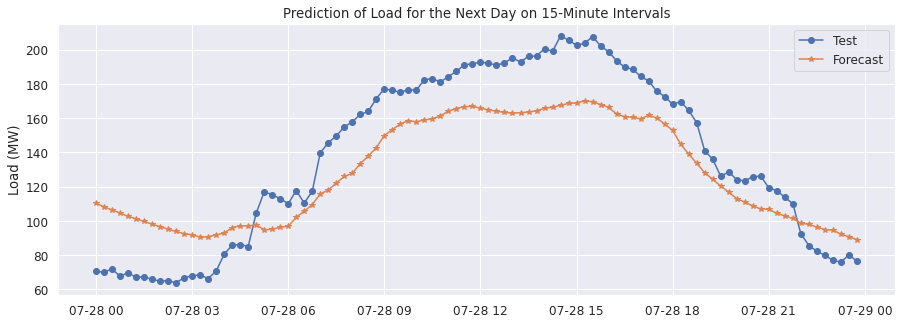

In [36]:
# Using the built models to make predictions for the next 24 hours (on 15-minute intervals)
predictions = daily_forecast(arima_model_daily, arima_model_pert, exog_test)
# Extracting the equivalent ground truth
ground_truth = data.loc[predictions.index, 'load']
# Plotting the results
plt.figure(figsize = (15, 5));
plt.plot(ground_truth, marker = 'o');
plt.plot(predictions, marker = '*');
plt.legend(['Test', 'Forecast'], loc = 'best');
plt.title('Prediction of Load for the Next Day on 15-Minute Intervals');
plt.ylabel('Load (MW)');
print('The Mean Absolute Deviation error:', round(MAD(ground_truth, predictions), 2))
print('The RMSE score:', round(RMSE(ground_truth, predictions), 2))
print(f'The MAPE score:{round(MAPE(ground_truth, predictions), 2)}%')

#### Notes:
To understand the variability of the model performance metrics, let's make predictions at different initial points, and calculate the error terms for each. Needless to say, the optimal parameters found from auto-ARIMA are being used for the models.

In [38]:
# Train sizes to be tried
train_size = [300, 301, 302, 303, 304] 
rmse_scores = []
mape_scores = []

# Looping over different train sizes to generate predictions with different initial conditions
# This helps to evaluate the average as well as the variability of the performance metrics
for train_days in train_size:
    # Building the training and test sets as well as required exogenous terms
    (train_hourly, test_hourly, train_daily, 
     test_daily, train_perturb, test_perturb,
     exog_train, exog_test) = create_weekly_and_hourly_data(data, train_days)

    # Building the daily and hourly perturbation models
    arima_model_daily = ARIMA(maxiter = 100, order = (1,1,3),
                              seasonal_order = (2,0,1,7), 
                              suppress_warnings = True)
    arima_model_daily.fit(train_daily)
    
    arima_model_pert = ARIMA(maxiter = 100, order = (4,0,0), 
                             seasonal_order = (4,0,1,24),
                             suppress_warnings = True)
    arima_model_pert.fit(train_perturb[-42*24:], X = exog_train[-42*24:])
    
    # Forming the forecasts (for the next day) and the ground truth 
    predictions = daily_forecast(arima_model_daily, arima_model_pert, exog_test)
    ground_truth = data.loc[predictions.index, 'load']
    
    # Calculating the performance metrics
    rmse_scores.append(RMSE(ground_truth, predictions))
    mape_scores.append(MAPE(ground_truth, predictions))

# Calculating average performance metrics and their 95% confidence intervals    
rmse_avg = np.mean(rmse_scores)
rmse_ci_lower = rmse_avg - 2*np.std(rmse_scores)
rmse_ci_upper = rmse_avg + 2*np.std(rmse_scores)
mape_avg = np.mean(mape_scores)
mape_ci_lower = mape_avg - 2*np.std(mape_scores)
mape_ci_upper = mape_avg + 2*np.std(mape_scores)

print(f'The average RMSE score of the model is {round(rmse_avg, 2)} and, with 95% confidence, ' +
      f'it falls between {round(rmse_ci_lower, 2)} and {round(rmse_ci_upper, 2)}.')
print(f'The average MAPE score of the model is {round(mape_avg, 2)}% and, with 95% confidence, ' +
      f'it falls between {round(mape_ci_lower, 2)}% and {round(mape_ci_upper, 2)}%.')

The average RMSE score of the model is 18.43 and, with 95% confidence, it falls between 7.77 and 29.09.
The average MAPE score of the model is 13.46% and, with 95% confidence, it falls between 5.17% and 21.74%.


## Time-Series Forecasting via XGBoost

In [75]:
# Building the dataset suitable for XGBoost model building
data_xgb = data[['load', 'year', 'month', 'day_of_week', 'hour_of_day']].copy()

# Separating target and predictors
X = data_xgb.drop('load', axis = 1)
y = data_xgb['load']

# Splitting the data into training and test sets (keeping the last month for testing) 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 304*24*4, shuffle = False)

#### Notes:

*   As can be seen, only features useful for an XGBoost model have been passed to its dataset. 
*   The model has been trained over 304 days, equivalent to the entire data except the last month (August).

MAPE score = 7.92%


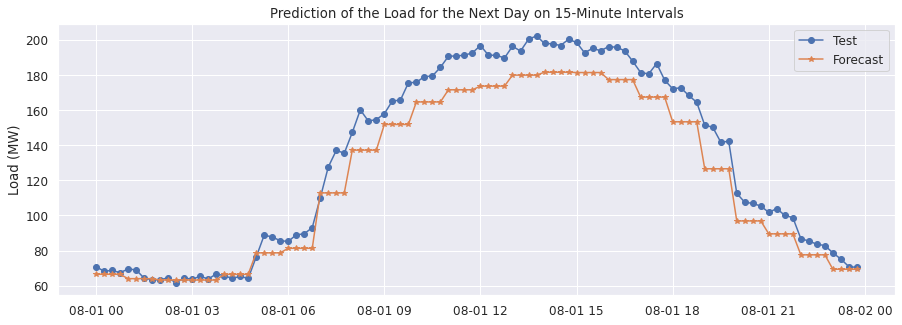

In [76]:
# Building a rudimentary XGBoost model
xgb0 = XGBRegressor(eval_metric = 'rmse', booster = 'gbtree', objective = 'reg:squarederror',
                    n_estimators = 1000, learning_rate = 0.01, early_stopping_rounds = 50,
                    random_state = 1)
xgb0.fit(X_train[:-24*4], y_train[:-24*4], 
         eval_set = [(X_train[-24*4:], y_train[-24*4:])], verbose = 0) 

# Checking the performance of the rudimentary model
X_test = X_test[:24*4]
y_test = y_test[:24*4]
preds = pd.Series(xgb0.predict(X_test), index = y_test.index)
plt.figure(figsize = (15, 5));
plt.plot(y_test.index, y_test, marker = 'o');
plt.plot(preds.index, preds, marker = '*');
plt.legend(['Test', 'Forecast'], loc = 'best');
plt.title('Prediction of the Load for the Next Day on 15-Minute Intervals');
plt.ylabel('Load (MW)');
mape_score = MAPE(y_test, preds)
print(f'MAPE score = {round(mape_score, 2)}%')

#### Observations:

*   The initial XGBoost model mostly uses its default hyperparameters, and only relies on features extracted from the datetime variable (day of week, hour, etc.). Its hyperparameters have been set so that it's compatible with a regression task and remains tree-based.
*   The large number of estimators and low learning rate help model capture different timescales, seasonalities and nonlinearities present in the time-series, and to ensure all relevant, generalizable information and patterns have been captured in an incremental fashion, so that the model isn't underfit. One should note that there is a trade-off between the two, i.e., a lower learning rate requires a larger number of estimators to attain an accurate model. We also remark that a very low value for learning rate can lead to overfitting.
*   The early_stopping_rounds is a hyperparameter that helps with reducing the chance of overfitting, as it terminates the training process if the selected accuracy metric doesn't improve on the validation set for as many steps as its value.
*   The validation and (the final) test sets of the tree-based models are all chosen to be 24-hour long, as the overall goal of the project is to develop a model skillful in forecasting the next 24 hours.
*   Even this simple XGBoost model appears to be far more superior to the ARIMA-based model. The skillfulness and reasonable execution time and computational cost of the tree-based models also eliminate any need for daily or hourly averaging of the load.  
*   One thing standing out about the predictions of the XGBoost model is that it's somewhat stepwise and remains constant for some contiguous points. This is owing to the piecewise nonlinearity of the method, and the fact that the regressors (hour, day of week, etc.) are all discrete and take only a few distinct values. 

In [77]:
# Building a function for adding lag features to the data
def add_lag_features(data, no_lag_days):
    '''This function receives the data and number of daily lag features
    it has to add the dataset, and returns the modified dataset will all
    new lag features. E.g., if no_lag_days = 2, it adds two columns two 
    the data, one with loads with 24 hours of lag and the other with loads
    with 48 hours of lag.'''
    
    # Ensuring the original data passed to the function doesn't change
    data_modified = data.copy()
    
    # Looping over lags and adding a corresponding lagged load in each iteration
    for i in range(1, no_lag_days+1):
        col = 'daily_lag' + str(i)
        data_modified[col] = data_modified.load.shift(i*24*4)
        
    return data_modified

#### Notes:
*   Calculating the lagged load with over a few lag values can overcome the piecewise-ness of predictions discussed previously, and improve the capabilities of the model in capturing the nonlinear variations.
*   The lowest unit of lag, here, is day, because choosing anything lower than that would've reduced the prediction horizon of the model to less than one day.   

In [78]:
# Determining the optimal value of lag using cross-validation

# Defining how to split the data between training and validation sets
splitter = TimeSeriesSplit(n_splits = 7, test_size = 24*4)

# Range of no. of lagged days
lag_days = np.arange(0, 8)
# Average cross-validation MAPE score of each lag
val_mape_scores = []

# Looping over given range of lags to find the one minimizing the MAPE score
for lag in lag_days:
    
    # Building a dataset including lagged features
    data_lagged = add_lag_features(data_xgb, lag).copy()  

    # Separating target and predictors
    X = data_lagged.drop('load', axis = 1)
    y = data_lagged['load']

    # Building the training data
    X_train_temp = X.iloc[:304*24*4]
    y_train_temp = y.iloc[:304*24*4]
        
    mape_score = 0
    for train_idx, val_idx in splitter.split(X_train_temp): 
        # Splitting training data into training and validation sets
        X_train_cv = X_train_temp.iloc[train_idx]
        y_train_cv = y_train_temp.iloc[train_idx]        
        X_val = X_train_temp.iloc[val_idx]
        y_val = y_train_temp.iloc[val_idx]
   
        # Fitting the model on training part
        xgb0.fit(X_train_cv[:-24*4], y_train_cv[:-24*4], 
                 eval_set = [(X_train_cv[-24*4:], y_train_cv[-24*4:])],
                 verbose = 0)
    
        # Calculating the score for validation part
        mape_score += MAPE(y_val, xgb0.predict(X_val))
    
    # Adding the average score to he list of MAPE scores
    val_mape_scores.append(mape_score/10)  

print('The lowest average MAPE score is achieved using lag = {} days.'.format(
            lag_days[np.array(val_mape_scores).argmin()]))

The lowest average MAPE score is achieved using lag = 3 days.


#### Observations:

*   The above manual grid search shows that adding three lagged features, with one-day, two-day and three-day lags, respectively, will minimize the MAPE score averaged over all validation sets.
*   Note that the difference between the time-series cross-validation and the cross-validation of a regular regression problem is that for the former, the validation is a moving window of the same size, and the training set expands as the validation set moves forward in time. Furthermore, the cross-validation data in a regular regression problem is often shuffled, while, here, the data is sequential. 
*   Although not shown here, our examinations showed that weekly lags don't improve the results.

In [79]:
# Building the new dataset using optimal lagging
data_xgb = add_lag_features(data_xgb, 3)

# Separating target and predictors
X = data_xgb.drop('load', axis = 1)
y = data_xgb['load']

# Splitting the data into training and test sets (keeping the last month for testing) 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 304*24*4, shuffle = False) 

In [85]:
# Defining the base estimator
#base_model = XGBRegressor(eval_metric = 'rmse', booster = 'gbtree', 
#                          objective = 'reg:squarederror', random_state = 1)

# Setting inverse of MAPE score as performance criterion
#performance_criterion = make_scorer(inverse_mape)

# Defining the range of hyperparameters
#hyperparams = {'n_estimators': np.arange(500, 2001, 500), 
#               'learning_rate': np.arange(0.005, 0.021, 0.005),
#               'max_depth': [3, 4, 5, 6]}

# Looping over the entire discretized hyperparameter space
#all_models = RandomizedSearchCV(estimator = base_model, param_distributions = hyperparams,
#                                scoring = performance_criterion, cv = splitter,
#                                n_iter = 20, n_jobs = -1, random_state = 1)
#all_models = all_models.fit(X_train, y_train)

# Choosing the best model
#xgb_tuned = all_models.best_estimator_
#print('Selected hyperparameters:\n', all_models.best_params_, sep = '')

Selected hyperparameters:
{'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.02}


#### Notes:

*   Here, the grid search is conducted in a randomized fashion, as there are too many combinations of hyprparameters to explore.
*   Again, since model tuning is a very time-consuming step, this block of the code is commented out and it was run only once to find the optimal hyperparameters. The obtained optimal values are being used in the next block to build the final model. One could uncomment this part of the code to redo the model tuning procedure with new sets of hyperparameters. 
*   Early stopping was removed during model tuning, as one of the hyperparameters of interest is number of estimators, and early termination of the model won't let its effect be fully studied.

The Mean Absolute Deviation error: 5.16
The RMSE score: 6.68
The MAPE score:3.91%


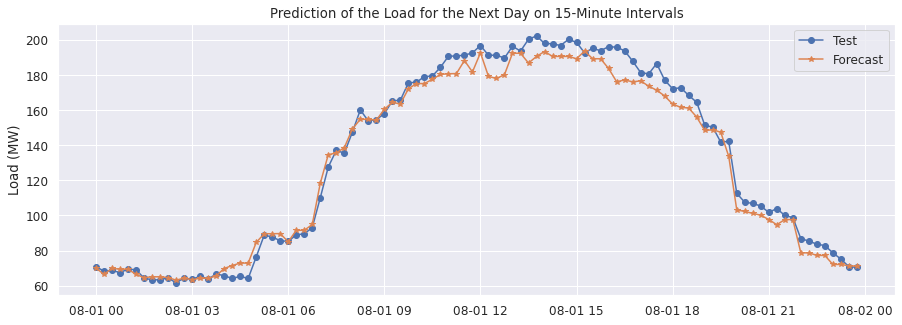

In [86]:
# Checking the performance of the final tuned model on the testing set

# Rebuilding the XGBoost model via the optimal hyperparameters found via cross-validation
# Here, we use early stopping too, to further reduce the chance of overfitting.
xgb_tuned = XGBRegressor(eval_metric = 'rmse', booster = 'gbtree', objective = 'reg:squarederror',
                         n_estimators = 1000, learning_rate = 0.02, max_depth = 5,
                         early_stopping_rounds = 50, random_state = 1)

# Rebuilding the training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 304*24*4, shuffle = False) 

# Putting aside one day of the testing data
X_test = X_test[:24*4]
y_test = y_test[:24*4]

# Re-fitting the model using optimal hyperparameters
xgb_tuned.fit(X_train[:-24*4], y_train[:-24*4], 
              eval_set = [(X_train[-24*4:], y_train[-24*4:])], verbose = 0)

# Making predictions for the next 24 hours 
preds = pd.Series(xgb_tuned.predict(X_test), index = y_test.index)

# Plotting the results
plt.figure(figsize = (15, 5));
plt.plot(y_test.index, y_test, marker = 'o');
plt.plot(preds.index, preds, marker = '*');
plt.legend(['Test', 'Forecast'], loc = 'best');
plt.title('Prediction of the Load for the Next Day on 15-Minute Intervals');
plt.ylabel('Load (MW)');

# Evaluating the performance metrics
print('The Mean Absolute Deviation error:', round(MAD(y_test, preds), 2))
print('The RMSE score:', round(RMSE(y_test, preds), 2))
print(f'The MAPE score:{round(MAPE(y_test, preds), 2)}%')

In [87]:
# Train sizes to be tried
train_size = [304, 305, 306, 307, 308] 
rmse_scores = []
mape_scores = []

for train_days in train_size:
    # Building the training and test sets for the certain training size
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, 
                                    train_size = train_days*24*4, shuffle = False) 
    X_test = X_test[:24*4]
    y_test = y_test[:24*4]    
    
    # Building the XGBoost model with the optimal hyperparameters
    xgb_tuned.fit(X_train[:-24*4], y_train[:-24*4], 
                  eval_set = [(X_train[-4*24:], y_train[-4*24:])],
                  verbose = 0)   
    
    # Generating the forecast values for the next day 
    preds = pd.Series(xgb_tuned.predict(X_test), index = y_test.index)
    
    # Calculating the performance metrics
    rmse_scores.append(RMSE(y_test, preds))
    mape_scores.append(MAPE(y_test, preds))

# Calculating average performance metrics and their 95% confidence intervals    
rmse_avg = np.mean(rmse_scores)
rmse_ci_lower = rmse_avg - 2*np.std(rmse_scores)
rmse_ci_upper = rmse_avg + 2*np.std(rmse_scores)
mape_avg = np.mean(mape_scores)
mape_ci_lower = mape_avg - 2*np.std(mape_scores)
mape_ci_upper = mape_avg + 2*np.std(mape_scores)

print(f'The average RMSE score of the model is {round(rmse_avg, 2)} and, with 95% confidence, ' +
      f'it falls between {round(rmse_ci_lower, 2)} and {round(rmse_ci_upper, 2)}.')
print(f'The average MAPE score of the model is {round(mape_avg, 2)}% and, with 95% confidence, ' +
      f'it falls between {round(mape_ci_lower, 2)}% and {round(mape_ci_upper, 2)}%.')

The average RMSE score of the model is 8.06 and, with 95% confidence, it falls between 3.24 and 12.88.
The average MAPE score of the model is 6.3% and, with 95% confidence, it falls between 2.97% and 9.63%.


#### Notes:

To find out the average performance scores of the model and their spread, the model was tested with different initial values.

## Time-Series Forecasting via Random Forest

In [88]:
# Building the dataset suitable for Random Forest model building
data_rf = data[['load', 'year', 'month', 'day_of_week', 'hour_of_day']].copy()

# Separating target and predictors
X = data_rf.drop('load', axis = 1)
y = data_rf['load']

# Splitting the data into training and test sets (keeping the last month for testing) 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 304*24*4, shuffle = False)

MAPE score = 6.74%


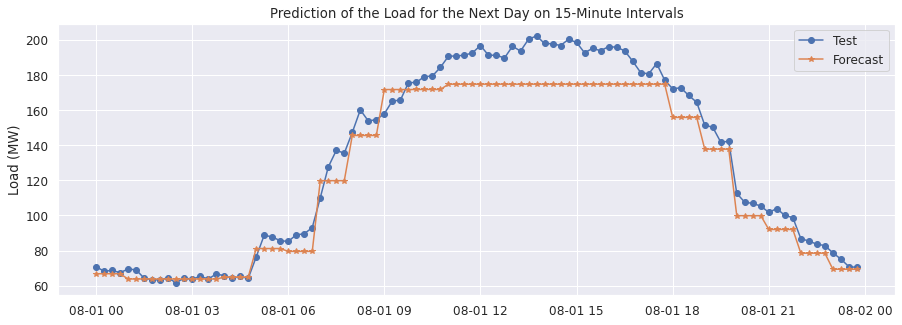

In [89]:
# Building a rudimentary Random Forest model
rf0 = RandomForestRegressor(n_estimators = 1000, max_depth = 8, random_state = 1, n_jobs = -1)
rf0.fit(X_train, y_train) 

# Checking the performance of the rudimentary model
X_test = X_test[:24*4]
y_test = y_test[:24*4]
preds = pd.Series(rf0.predict(X_test), index = y_test.index)
plt.figure(figsize = (15, 5));
plt.plot(y_test.index, y_test, marker = 'o');
plt.plot(preds.index, preds, marker = '*');
plt.legend(['Test', 'Forecast'], loc = 'best');
plt.title('Prediction of the Load for the Next Day on 15-Minute Intervals');
plt.ylabel('Load (MW)');
mape_score = MAPE(y_test, preds)
print(f'MAPE score = {round(mape_score, 2)}%')

#### Notes:

*   Similar to the procedure taken for building the XGBoost model, most hyperparameters of the Random Forest model have been left at their default values. Only the maximum depth has been capped to somewhat reduce overfitting and the no. of estimators have been remarkably increased to attain a more reliable model.
*   Even more strikingly than the XGBoost model with no lag features, and for the same reasons, the predictions of the preliminary Random Forest model is fairly piecewise. 

In [90]:
# Building a function for adding lag features to the data
def add_lag_features_rf(data, no_lag_days):
    '''Similar to lag creation function of XGBoost, but since Random Forest 
    doesn't work with missing values, rows with NANs are dropped.'''
    
    # Making sure the original dataset passed to the function doesn't change
    data_modified = data.copy()
    
    # Adding laged columns to the data
    for i in range(1, no_lag_days+1):
        col = 'daily_lag' + str(i)
        data_modified[col] = data_modified.load.shift(i*24*4)
    
    # Only retaining rows with no NANs
    data_modified = data_modified.iloc[no_lag_days*24*4:, :]
    
    return data_modified

In [91]:
# Determining the optimal lag value using cross-validation

# Defining how to split the data between training and validation sets
splitter = TimeSeriesSplit(n_splits = 7, test_size = 24*4)

# Range of no. of lagged days
lag_days = np.arange(0, 8)
# Average cross-validation MAPE score of each lag
val_mape_scores = []

# Looping over given range of lags to find the one minimizing the MAPE score
for lag in lag_days:
    
    # Building a dataset including lagged features
    data_lagged = add_lag_features_rf(data_rf, lag).copy()  

    # Separating target and predictors
    X = data_lagged.drop('load', axis = 1)
    y = data_lagged['load']

    # Building the training data (keeping the last month for training)
    X_train_temp = X.loc[X.index.month != 8]
    y_train_temp = y.loc[y.index.month != 8]
            
    mape_score = 0
    for train_idx, val_idx in splitter.split(X_train_temp): 
        # Splitting training data into training and validation sets
        X_train_cv = X_train_temp.iloc[train_idx]
        y_train_cv = y_train_temp.iloc[train_idx]        
        X_val = X_train_temp.iloc[val_idx]
        y_val = y_train_temp.iloc[val_idx]
   
        # Fitting the model on training part
        rf0.fit(X_train_cv, y_train_cv)
    
        # Calculating the score for validation part
        mape_score += MAPE(y_val, rf0.predict(X_val))
    
    # Adding the average score to he list of MAPE scores
    val_mape_scores.append(mape_score/10)  

print('The lowest average MAPE score is achieved using lag = {} days.'.format(
            lag_days[np.array(val_mape_scores).argmin()]))

The lowest average MAPE score is achieved using lag = 3 days.


#### Observations:

Similar to the XGBoost model, using three lag features, lagged respectively by one, two and three days, respectively, appears to be the optimal choice.

In [92]:
# Building the new dataset using optimal lagging
data_rf = add_lag_features_rf(data_rf, 3)

# Separating target and predictors
X = data_rf.drop('load', axis = 1)
y = data_rf['load']

# Splitting the data into training and test sets (keeping the last month for testing) 
X_train = X.loc[X.index.month != 8]
y_train = y.loc[y.index.month != 8]
X_test  = X.loc[X.index.month == 8]
y_test  = y.loc[y.index.month == 8]  

In [93]:
# Defining the base estimator
#base_model = RandomForestRegressor(random_state = 1)

# Setting inverse of MAPE score as performance criterion
#performance_criterion = make_scorer(inverse_mape)

# Defining the range of hyperparameters
#hyperparams = {'n_estimators': np.arange(1000, 3001, 500), 
#               'min_samples_leaf': [1, 3, 5],
#               'max_depth': [6, 8, 10, 12]}

# Looping over the entire discretized hyperparameter space
#all_models = RandomizedSearchCV(estimator = base_model, param_distributions = hyperparams,
#                                scoring = performance_criterion, cv = splitter,
#                                n_iter = 15, n_jobs = -1, random_state = 1)
#all_models = all_models.fit(X_train, y_train)

# Choosing the best model
#rf_tuned = all_models.best_estimator_
#rf_tuned = rf_tuned.fit(X_train, y_train)
#print('Selected hyperparameters:\n', all_models.best_params_, sep = '')

Selected hyperparameters:
{'n_estimators': 2500, 'min_samples_leaf': 3, 'max_depth': 12}


#### Notes:

*   Again, the hyperparameters are found via a randomized procedure. 
*   Due to its massive time and computational costs, the block corresponding to the model tuning process of the Random Forest model is also commented out. The optimal hyperparameters obtained using this search are passed to the final model of the next block.  

The Mean Absolute Deviation error: 6.33
The RMSE score: 8.78
The MAPE score:4.85%


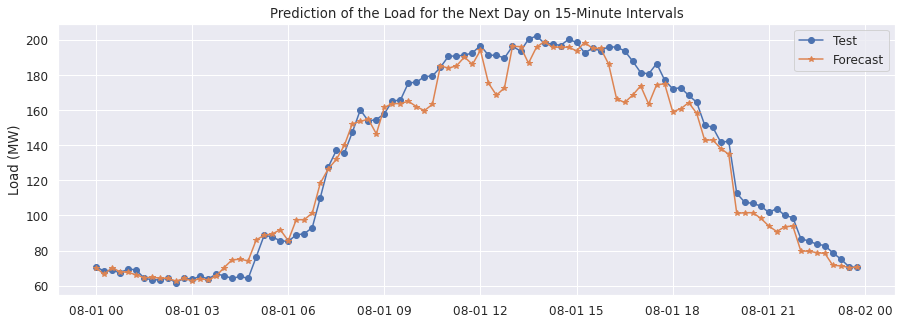

In [94]:
# Checking the performance of the final tuned model on the testing set

# Re-building the model using the optimal hyperparameters found via cross-validation  
rf_tuned = RandomForestRegressor(n_estimators = 2500, min_samples_leaf = 3, 
                                 max_depth = 12, n_jobs = -1, random_state = 1)

# Re-building the training and test sets 
X_train = X.loc[X.index.month != 8]
y_train = y.loc[y.index.month != 8]
X_test  = X.loc[X.index.month == 8]
y_test  = y.loc[y.index.month == 8]  

# Putting aside one day of the testing data
X_test = X_test[:24*4]
y_test = y_test[:24*4]

# Re-fitting the model using optimal hyperparameters
rf_tuned.fit(X_train, y_train)

# Making predictions for the next 24 hours 
preds = pd.Series(rf_tuned.predict(X_test), index = y_test.index)

# Plotting the results
plt.figure(figsize = (15, 5));
plt.plot(y_test.index, y_test, marker = 'o');
plt.plot(preds.index, preds, marker = '*');
plt.legend(['Test', 'Forecast'], loc = 'best');
plt.title('Prediction of the Load for the Next Day on 15-Minute Intervals');
plt.ylabel('Load (MW)');

# Evaluating the performance metrics
print('The Mean Absolute Deviation error:', round(MAD(y_test, preds), 2))
print('The RMSE score:', round(RMSE(y_test, preds), 2))
print(f'The MAPE score:{round(MAPE(y_test, preds), 2)}%')

In [95]:
# Train sizes to be tried
train_size = [301, 302, 303, 304, 305] 
rmse_scores = []
mape_scores = []

for train_days in train_size:
    # Building the training and test sets for the certain training size
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, 
                                    train_size = train_days*24*4, shuffle = False) 
    X_test = X_test[:24*4]
    y_test = y_test[:24*4]    
    
    # Building the Random Forest model with the optimal hyperparameters
    rf_tuned.fit(X_train, y_train)   
    
    # Generating the forecast values for the next day 
    preds = pd.Series(rf_tuned.predict(X_test), index = y_test.index)
    
    # Calculating the performance metrics
    rmse_scores.append(RMSE(y_test, preds))
    mape_scores.append(MAPE(y_test, preds))

# Calculating average performance metrics and their 95% confidence intervals    
rmse_avg = np.mean(rmse_scores)
rmse_ci_lower = rmse_avg - 2*np.std(rmse_scores)
rmse_ci_upper = rmse_avg + 2*np.std(rmse_scores)
mape_avg = np.mean(mape_scores)
mape_ci_lower = mape_avg - 2*np.std(mape_scores)
mape_ci_upper = mape_avg + 2*np.std(mape_scores)

print(f'The average RMSE score of the model is {round(rmse_avg, 2)} and, with 95% confidence, ' +
      f'it falls between {round(rmse_ci_lower, 2)} and {round(rmse_ci_upper, 2)}.')
print(f'The average MAPE score of the model is {round(mape_avg, 2)}% and, with 95% confidence, ' +
      f'it falls between {round(mape_ci_lower, 2)}% and {round(mape_ci_upper, 2)}%.')

The average RMSE score of the model is 7.77 and, with 95% confidence, it falls between 3.09 and 12.45.
The average MAPE score of the model is 5.77% and, with 95% confidence, it falls between 3.19% and 8.36%.


#### Notes:

However the XGBoost renders lower errors for the plotted subset of the test data (first day of August), the error metrics of the Random Forest model averaged over several test sets with different initial points are slightly lower.  

## Relative Importance of Features

Here, we examine which features prove to be more impactful on the predictions of the tree-based models. 

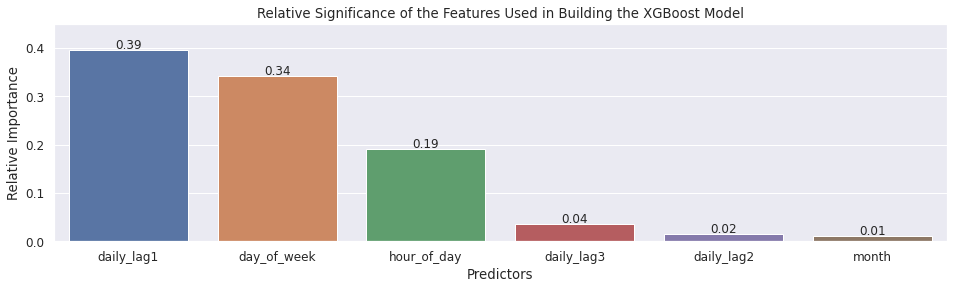

In [100]:
# Making a dataframe of relative importance of all predictors
imp_df = pd.DataFrame({'Predictors': X.columns.tolist(), 'Relative Importance': 
                        xgb_tuned.feature_importances_})
imp_df = imp_df.loc[imp_df['Relative Importance'] > 0.01]
imp_df = imp_df.sort_values(by = 'Relative Importance', ascending = False).reset_index(drop = True)

# Demonstrating the relative importance of the XGBoost predictors in the form of a barplot
plt.figure(figsize = (16, 4));
barplt = sns.barplot(data = imp_df, x = 'Predictors', y = 'Relative Importance');
plt.title('Relative Significance of the Features Used in Building the XGBoost Model');
countplot_labeling(barplt, imp_df, perc = False, decimal = 2);
plt.ylim(0, 0.45);

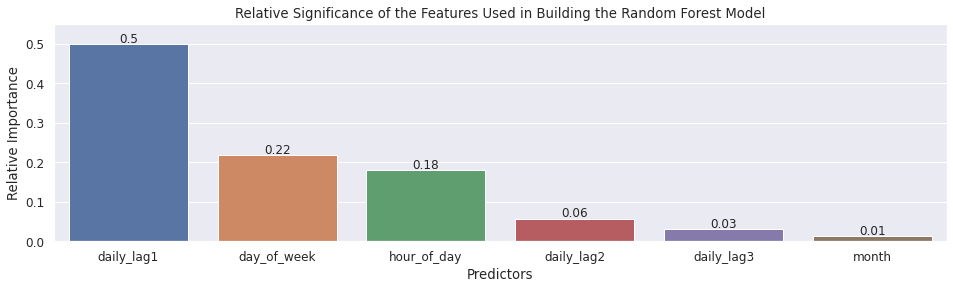

In [102]:
# Making a dataframe of relative importance of all predictors
imp_df = pd.DataFrame({'Predictors': X.columns.tolist(), 'Relative Importance': 
                        rf_tuned.feature_importances_})
imp_df = imp_df.loc[imp_df['Relative Importance'] > 0.01]
imp_df = imp_df.sort_values(by = 'Relative Importance', ascending = False).reset_index(drop = True)

# Demonstrating the relative importance of the Random Forest predictors in the form of a barplot
plt.figure(figsize = (16, 4));
barplt = sns.barplot(data = imp_df, x = 'Predictors', y = 'Relative Importance');
plt.title('Relative Significance of the Features Used in Building the Random Forest Model');
countplot_labeling(barplt, imp_df, perc = False, decimal = 2);
plt.ylim(0, 0.55);

## Summary

*   Three different approaches were adopted to address the objective of this time-series forecasting project: stiatistical regression method of SARIMAX, the boosting ensemble method of XGBoost, and the bagging ensemble method of Random Forest. Note that the last two methods are tree-based.
*   While Random Forest and XGBoost return very good performance scores (average cross-validated MAPE scores of 5.77% and 6.30%, respectively), SARIMAX emerges far more inferior to the other two with the average MAPE score equal to 13.46%. The ARIMA-based model really suffers from accurately capturing the nonlinearities as well as mixed timescales and seasonalities and variations on small timescales (hourly basis or shorter). The ARIMA-based model is also more time-consuming and sensitive to the constraints on computational resources.
*   Another major issue with the ARIMA predictions is that in peak hours, when the load on the grid is high, they noticeably underpredict the load, and in down hours, when the load is low, overpredict it.
*   The confidence intervals of the performance scores of all methods have been reported in their corresponding sections by generating their predictions for multiple testing sets with different initial values. The SARIMAX model has the widest confidence interval (uncertainty region), further confirming its lesser reliability in comparison with the two other models. 
*   According to both tree-based models, one-day-lagged load, the day of the week and the hour of the day are respectively the most important predictors.